In [1]:
#import packages
import isotopylog as ipl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.optimize import fsolve, minimize

# 读取CSV文件
df = pd.read_csv('./datasets/Thermal_History.csv')

# 提取四个变量
time = df['Time/Myr'].values
avg_temp = df['Avg_T/Celsius'].values + 273.15
min_temp = df['Min_T/Celsius'].values + 273.15
max_temp = df['Max_T/Celsius'].values + 273.15

# 查看提取的变量
print(time[:5], avg_temp[:5], min_temp[:5], max_temp[:5])

[0.  0.5 1.  1.5 2. ] [282.1871  282.30151 282.38004 282.45687 282.53019] [271.45723 273.15    273.15    273.15    273.15   ] [292.917 290.15  290.15  290.15  290.15 ]


In [2]:
# 读取CSV文件
df_test = pd.read_csv('./datasets/acutal_test.csv')

# 提取四个变量
delta47 = df_test['Delta47'].values
delta47_err = df_test['SD'].values

# 查看提取的变量
print(delta47[:5], delta47_err[:5])

[0.52977419 0.54193119 0.53531304 0.5306656  0.52418016] [0.01969626 0.02042836 0.01822344 0.01012626 0.01777386]


In [3]:
def constrained_u_fit(time, values, start_x, end_x, new_max_temp, plot=False):
    """
    拟合带约束的倒转U型四次多项式曲线，确保端点值、端点导数连续，中点最大值，并平滑过渡。
    
    参数:
    - time: np.ndarray, x坐标数组
    - values: np.ndarray, 原始数据的y值
    - start_x: float, 区间的起始x值
    - end_x: float, 区间的结束x值
    - new_max_temp: float, 目标最大温度值
    - plot: bool, 是否绘制结果图像
    
    返回:
    - adjusted_values: np.ndarray, 调整后的整体数据数组
    """
    # 提取局部区间的数据
    mask = (time >= start_x) & (time <= end_x)
    local_time = time[mask]
    local_values = values[mask]

    # 获取起点、终点的值
    start_value = local_values[0]
    end_value = local_values[-1]
    mid_x = (start_x + end_x) / 2  # 极值点
    start_slope = (local_values[1] - local_values[0]) / (local_time[1] - local_time[0])  # 近似起点斜率

    # 定义四次多项式及其导数
    def polynomial(x, a, b, c, d, e):
        return a * x**4 + b * x**3 + c * x**2 + d * x + e

    def polynomial_derivative(x, a, b, c, d):
        return 4 * a * x**3 + 3 * b * x**2 + 2 * c * x + d

    # 定义约束方程
    def constraints(params):
        a, b, c, d, e = params
        eq1 = polynomial(start_x, a, b, c, d, e) - start_value           # 起点值
        eq2 = polynomial_derivative(start_x, a, b, c, d) - start_slope   # 起点斜率
        eq3 = polynomial(end_x, a, b, c, d, e) - end_value               # 终点值
        eq4 = polynomial(mid_x, a, b, c, d, e) - new_max_temp            # 中点最大值
        eq5 = polynomial_derivative(mid_x, a, b, c, d)                   # 中点处导数为0
        return [eq1, eq2, eq3, eq4, eq5]

    # 求解四次多项式系数
    initial_guess = [0, 0, 0, start_slope, start_value]
    params = fsolve(constraints, initial_guess)
    a, b, c, d, e = params

    # 生成拟合曲线
    adjusted_local_values = polynomial(local_time, a, b, c, d, e)

    # 拼接数据
    adjusted_values = values.copy()
    adjusted_values[mask] = adjusted_local_values

    # 绘图
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(time, values, label='Original Curve', color='red', linewidth=1.5)
        plt.plot(local_time, adjusted_local_values, label='Adjusted U-shaped Curve', color='blue', linewidth=2)
        plt.scatter(mid_x, new_max_temp, color='orange', s=100, label='New Top Point (%.2f, %.2f)' % (mid_x, new_max_temp))
        plt.axvline(x=start_x, color='gray', linestyle='--', label='Region Start')
        plt.axvline(x=end_x, color='gray', linestyle='--', label='Region End')
        plt.xlabel('Time (Myr)')
        plt.ylabel('Temperature')
        plt.legend()
        plt.title('Smooth U-shaped Curve with Endpoint and Slope Constraints')
        plt.show()

    return adjusted_values

f:\Anaconda3\envs\clump\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


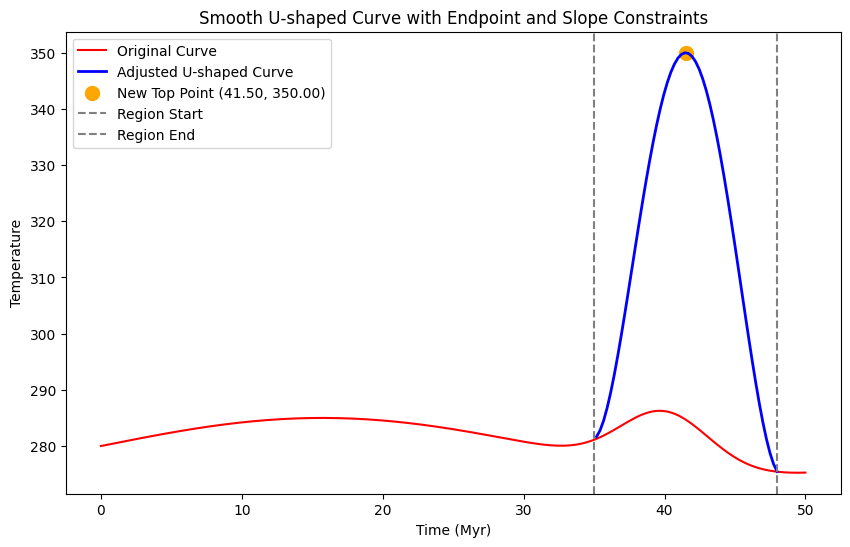

In [4]:
# 示例数据
time_ex = np.linspace(0, 50, 200)
values_ex = 280 + 5 * np.sin(0.1 * time_ex) + 10 * np.exp(-0.05 * (time_ex - 40) ** 2)  # 模拟数据

# 调用函数
start_x = 35
end_x = 48
new_max_temp = 350  # 目标最大温度值
adjusted_values = constrained_u_fit(time_ex, values_ex, start_x, end_x, new_max_temp, plot=True)

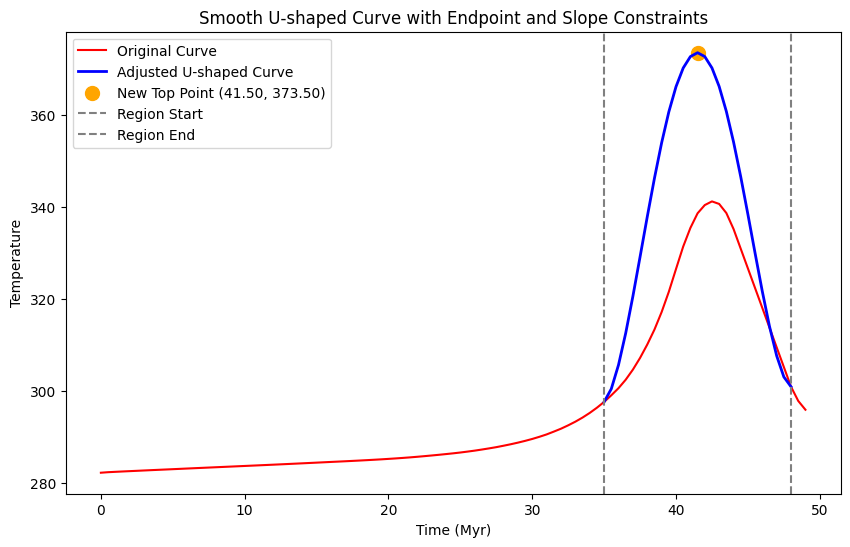

In [5]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48
new_max_temp = 100 + 273.5  # 目标最大温度值
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_200_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

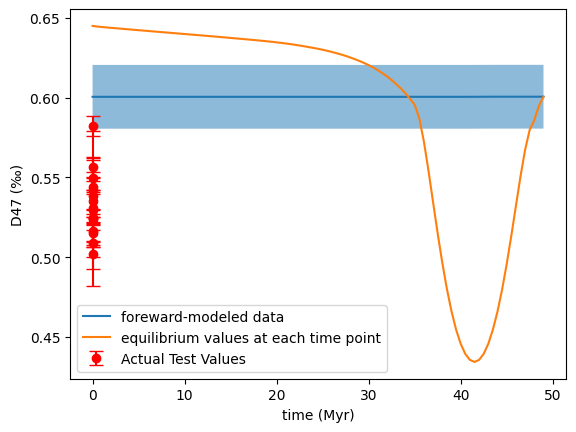

In [6]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

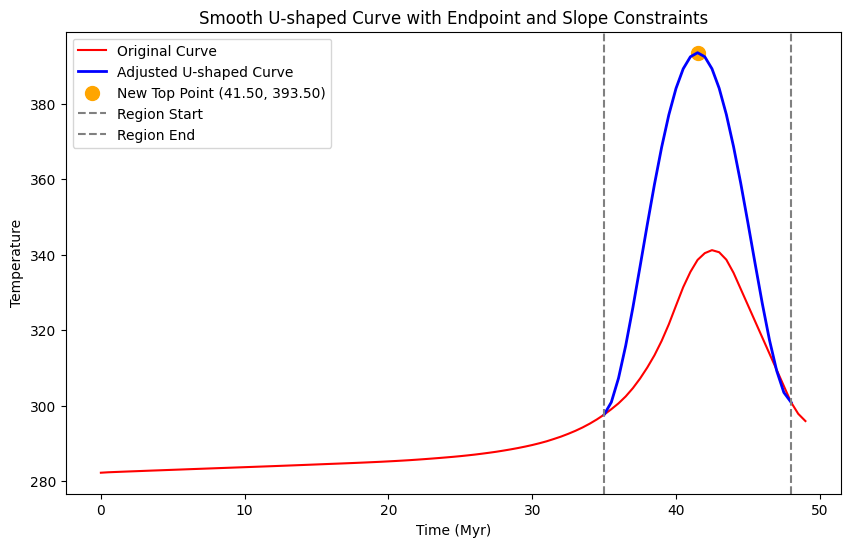

In [8]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48
new_max_temp = 120 + 273.5  # 目标最大温度值
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_200_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

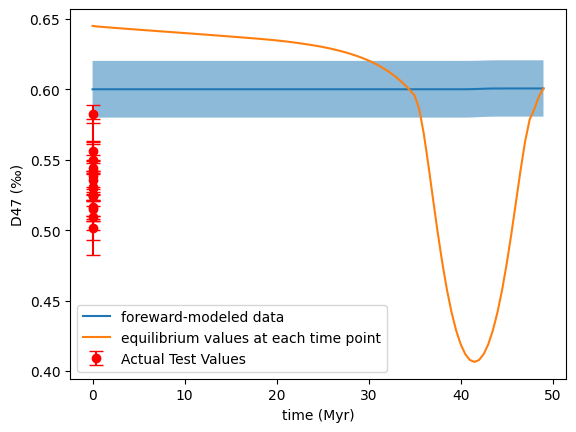

In [9]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

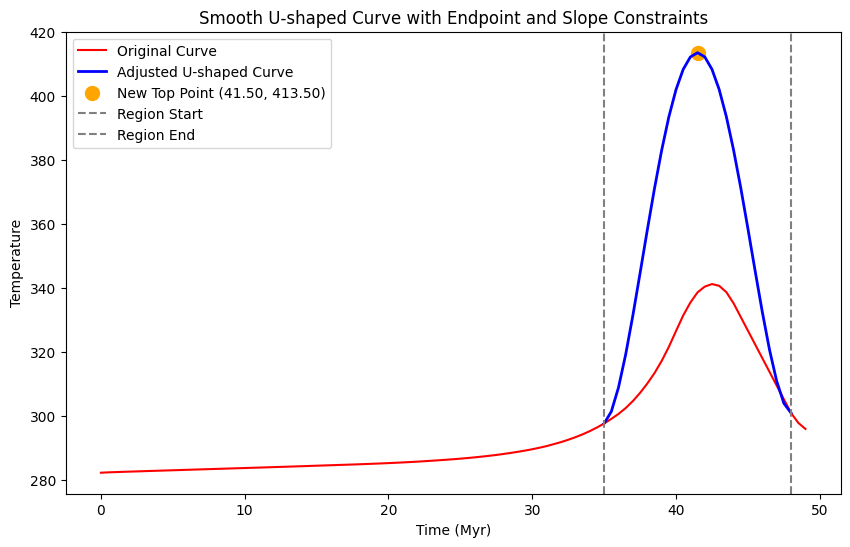

In [10]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48
new_max_temp = 140 + 273.5  # 目标最大温度值
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_200_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

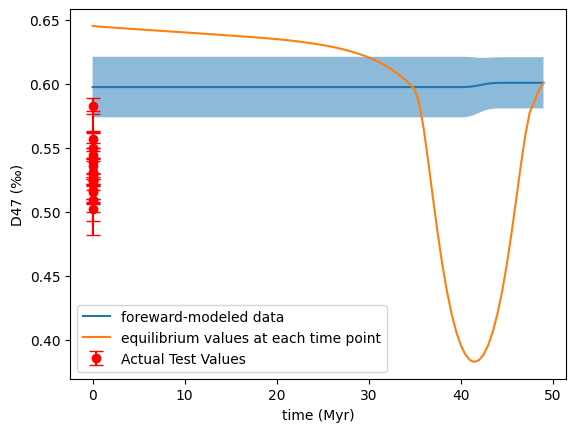

In [11]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

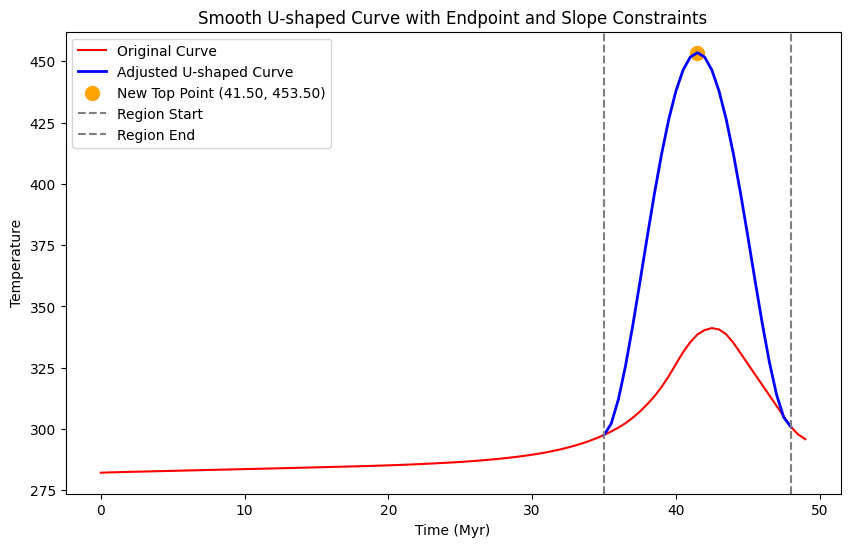

In [12]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48
new_max_temp = 180 + 273.5  # 目标最大温度值
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_200_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

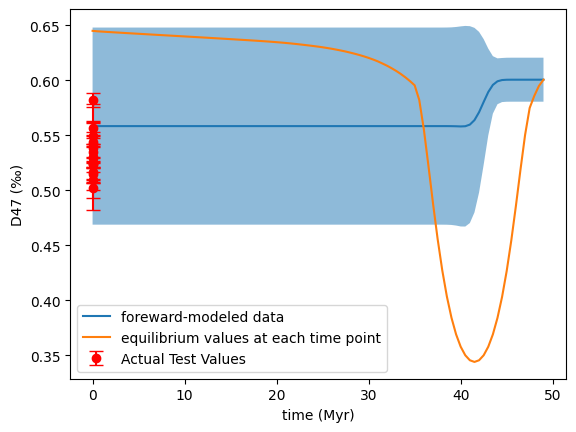

In [13]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

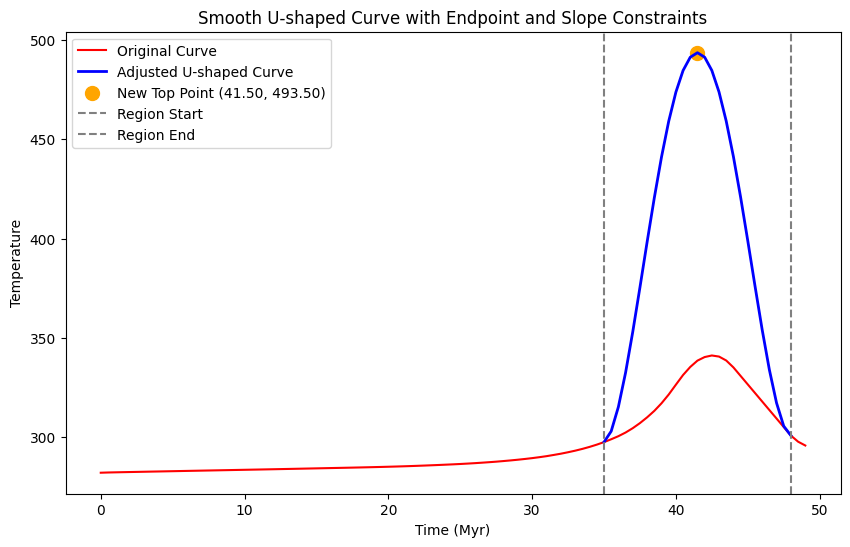

In [14]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48
new_max_temp = 220 + 273.5  # 目标最大温度值
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_200_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

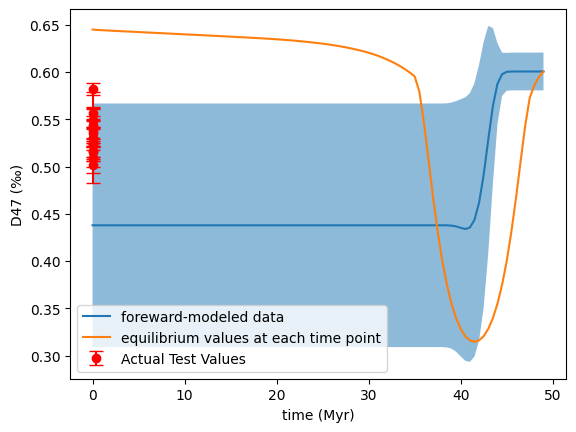

In [15]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

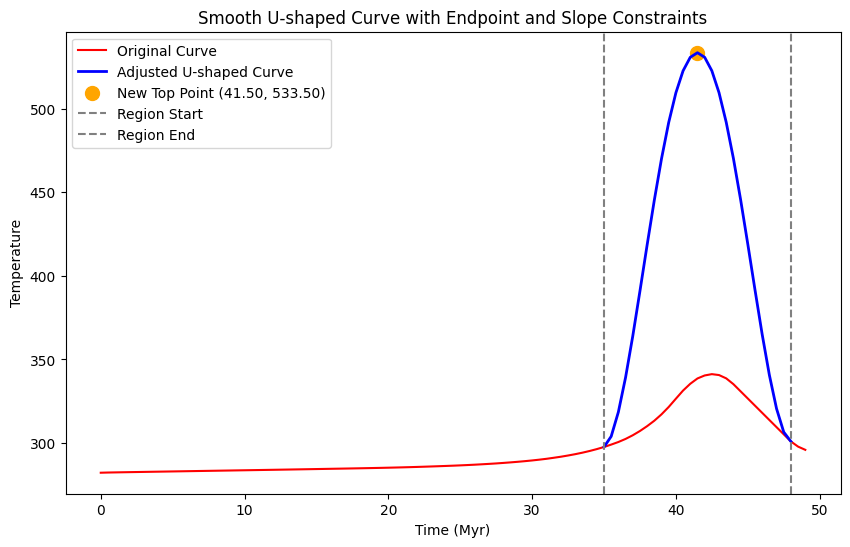

In [16]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48
new_max_temp = 260 + 273.5  # 目标最大温度值
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_200_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

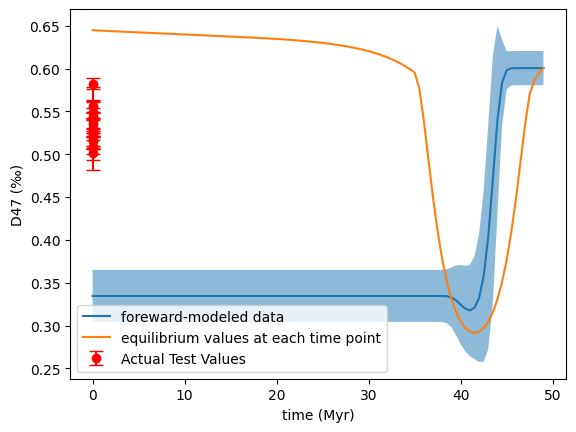

In [17]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

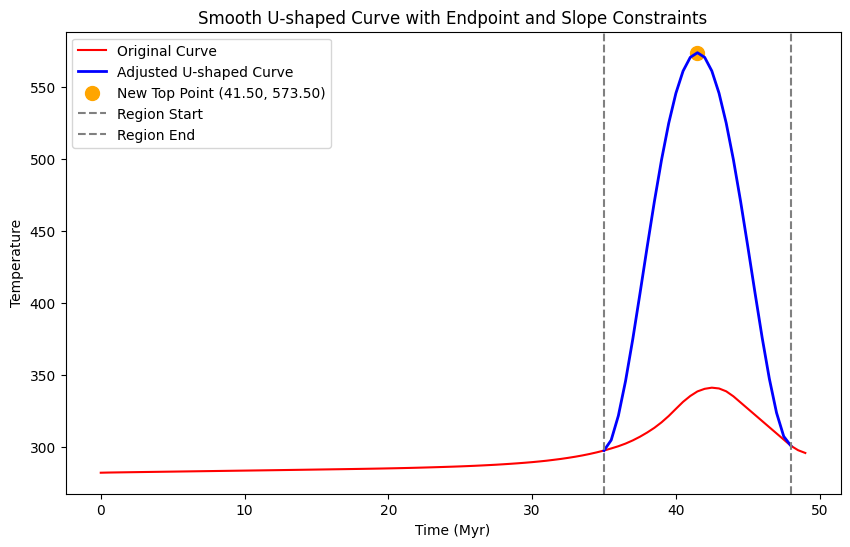

In [18]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48
new_max_temp = 300 + 273.5  # 目标最大温度值
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_200_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

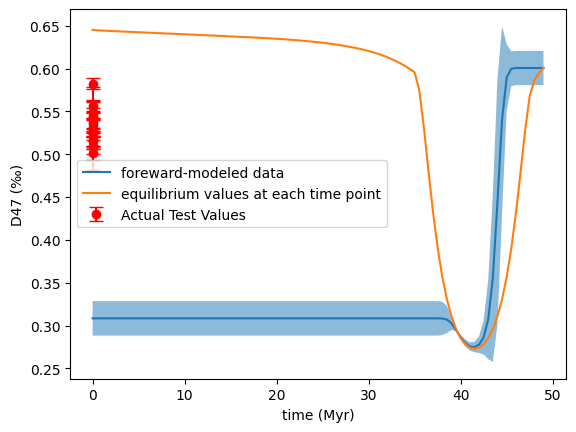

In [19]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

In [20]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 35
end_time = 48

new_max_temp_100 = 100 + 273.5
new_max_temp_140 = 140 + 273.5
new_max_temp_180 = 180 + 273.5
new_max_temp_220 = 220 + 273.5
new_max_temp_260 = 260 + 273.5
new_max_temp_300 = 300 + 273.5

T_100_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_100, plot=False)
T_140_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_140, plot=False)
T_180_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_180, plot=False)
T_220_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_220, plot=False)
T_260_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_260, plot=False)
T_300_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_300, plot=False)

T_ini = avg_temp[::-1]
#make D0 in equilibrium
D0_ini = ipl.Deq_from_T(avg_temp[0])
d0_ini = [D0_ini, 0, 0] # d13C and d18O of zero

T_100 = T_100_avg[::-1]
#make D0 in equilibrium
D0_100 = ipl.Deq_from_T(T_100[0])
d0_100 = [D0_100, 0, 0] # d13C and d18O of zero

T_140 = T_140_avg[::-1]
#make D0 in equilibrium
D0_140 = ipl.Deq_from_T(T_140[0])
d0_140 = [D0_140, 0, 0] # d13C and d18O of zero

T_180 = T_180_avg[::-1]
#make D0 in equilibrium
D0_180 = ipl.Deq_from_T(T_180[0])
d0_180 = [D0_180, 0, 0] # d13C and d18O of zero

T_220 = T_220_avg[::-1]
#make D0 in equilibrium
D0_220 = ipl.Deq_from_T(T_220[0])
d0_220 = [D0_220, 0, 0] # d13C and d18O of zero

T_260 = T_260_avg[::-1]
#make D0 in equilibrium
D0_260 = ipl.Deq_from_T(T_260[0])
d0_260 = [D0_260, 0, 0] # d13C and d18O of zero

T_300 = T_300_avg[::-1]
#make D0 in equilibrium
D0_300 = ipl.Deq_from_T(T_300[0])
d0_300 = [D0_300, 0, 0] # d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 # convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1] # original time scale is Myr

#now calculate D at each time point
D_ini, Dstd_ini = ipl.geologic_history(tSecond, T_ini, ed, d0_ini, d0_std = d0_std)
D_100, Dstd_100 = ipl.geologic_history(tSecond, T_100, ed, d0_100, d0_std = d0_std)
D_140, Dstd_140 = ipl.geologic_history(tSecond, T_140, ed, d0_140, d0_std = d0_std)
D_180, Dstd_180 = ipl.geologic_history(tSecond, T_180, ed, d0_180, d0_std = d0_std)
D_220, Dstd_220 = ipl.geologic_history(tSecond, T_220, ed, d0_220, d0_std = d0_std)
D_260, Dstd_260 = ipl.geologic_history(tSecond, T_260, ed, d0_260, d0_std = d0_std)
D_300, Dstd_300 = ipl.geologic_history(tSecond, T_300, ed, d0_300, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq_ini = ipl.Deq_from_T(T_ini)
Deq_100 = ipl.Deq_from_T(T_100_avg)
Deq_140 = ipl.Deq_from_T(T_140_avg)
Deq_180 = ipl.Deq_from_T(T_180_avg)
Deq_220 = ipl.Deq_from_T(T_220_avg)
Deq_260 = ipl.Deq_from_T(T_260_avg)
Deq_300 = ipl.Deq_from_T(T_300_avg)

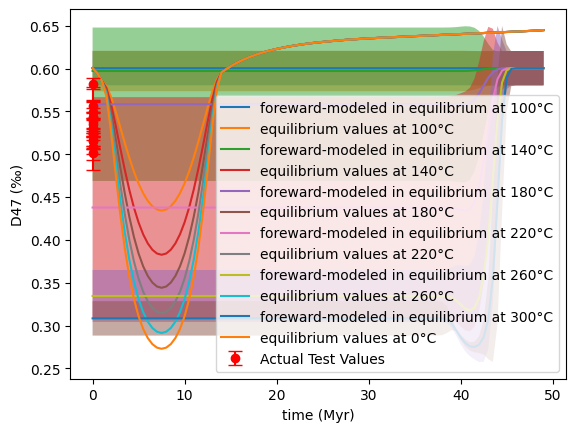

In [21]:
fig,ax = plt.subplots(1,1)

ax.plot(tmyr, D_100, label = 'foreward-modeled in equilibrium at 100°C')
ax.fill_between(tmyr, D_100 - Dstd_100, D_100 + Dstd_100, alpha = 0.5)
ax.plot(tmyr, Deq_100, label = 'equilibrium values at 100°C')

ax.plot(tmyr, D_140, label = 'foreward-modeled in equilibrium at 140°C')
ax.fill_between(tmyr, D_140 - Dstd_140, D_140 + Dstd_140, alpha = 0.5)
ax.plot(tmyr, Deq_140, label = 'equilibrium values at 140°C')

ax.plot(tmyr, D_180, label = 'foreward-modeled in equilibrium at 180°C')
ax.fill_between(tmyr, D_180 - Dstd_180, D_180 + Dstd_180, alpha = 0.5)
ax.plot(tmyr, Deq_180, label = 'equilibrium values at 180°C')

ax.plot(tmyr, D_220, label = 'foreward-modeled in equilibrium at 220°C')
ax.fill_between(tmyr, D_220 - Dstd_220, D_220 + Dstd_220, alpha = 0.5)
ax.plot(tmyr, Deq_220, label = 'equilibrium values at 220°C')

ax.plot(tmyr, D_260, label = 'foreward-modeled in equilibrium at 260°C')
ax.fill_between(tmyr, D_260 - Dstd_260, D_260 + Dstd_260, alpha = 0.5)
ax.plot(tmyr, Deq_260, label = 'equilibrium values at 260°C')

ax.plot(tmyr, D_300, label = 'foreward-modeled in equilibrium at 300°C')
ax.fill_between(tmyr, D_300 - Dstd_300, D_300 + Dstd_300, alpha = 0.5)
ax.plot(tmyr, Deq_300, label = 'equilibrium values at 0°C')

ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

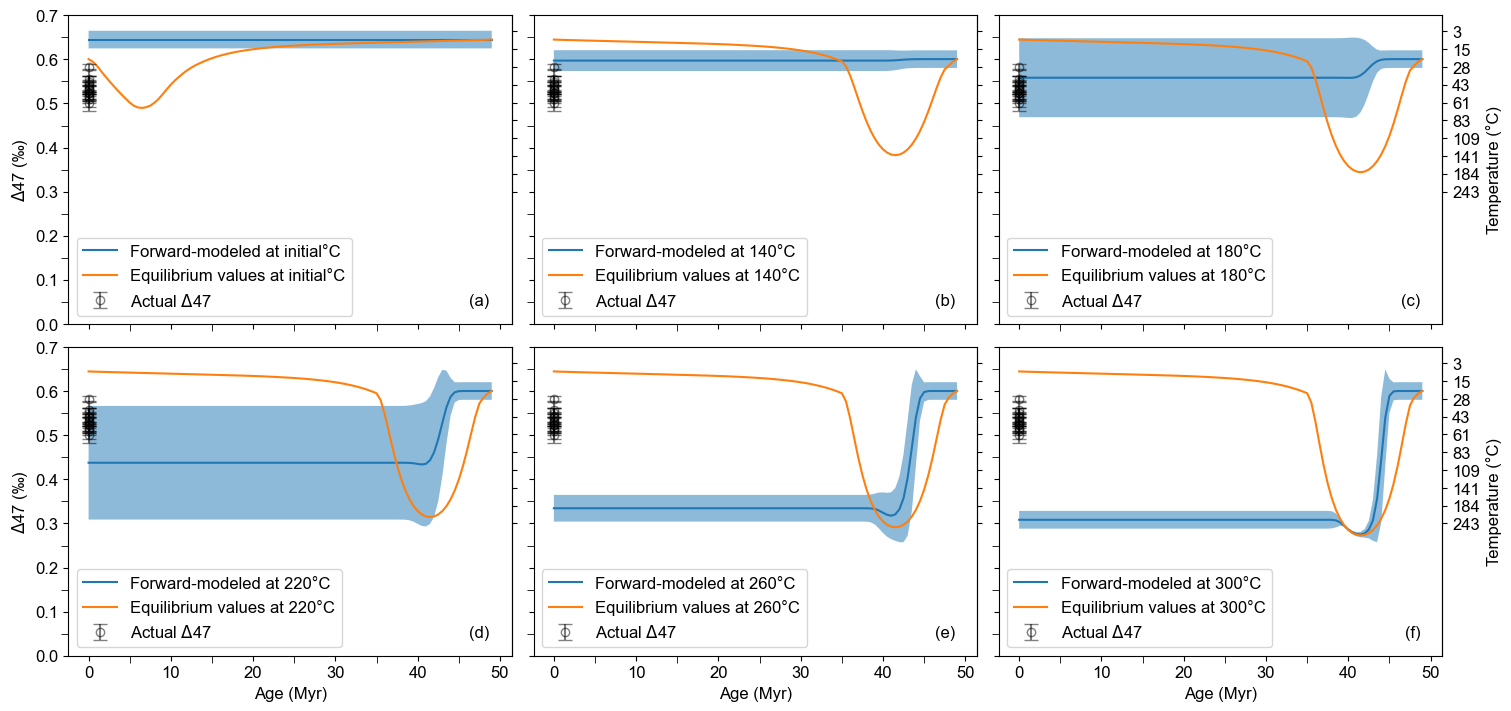

In [54]:
plt.rcParams["font.family"] = "Arial"  # 设置全局字体为 Arial

d47_range = np.linspace(0.15, 0.68, 6)
temp_values = [int(ipl.T_from_Deq(delta)) for delta in d47_range]  # 转换为温度并取整

fig, axes = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True, constrained_layout=True)

# 定义温度数据及其对应的子图索引
temperatures = ['initial', 140, 180, 220, 260, 300]
data = [
    (D_ini, Dstd_ini, Deq_ini),
    (D_140, Dstd_140, Deq_140),
    (D_180, Dstd_180, Deq_180),
    (D_220, Dstd_220, Deq_220),
    (D_260, Dstd_260, Deq_260),
    (D_300, Dstd_300, Deq_300)
]

# 遍历每个温度和子图
for i, (temp, ax, (D, Dstd, Deq)) in enumerate(zip(temperatures, axes.flatten(), data)):
    ax.plot(tmyr, D, label=f'Forward-modeled at {temp}°C')
    ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha=0.5)
    ax.plot(tmyr, Deq[::-1], label=f'Equilibrium values at {temp}°C')
    
    ax.errorbar([0] * len(delta47),
                 delta47, yerr=delta47_err,
                 fmt='o', label='Actual $\Delta$47',
                 color='black',
                 capsize=5,
                 alpha=0.5,
                 markerfacecolor='none')
    
    ax.set_ylim(0.15, 0.68)
    
    if i >= 3:  # 仅在最后一行子图设置 xlabel
        ax.set_xlabel('Age (Myr)')
    if i % 3 == 0:  # 仅在每行的第一个子图设置 ylabel
        ax.set_ylabel('$\Delta$47 (‰)')

    # 添加右边的 y 轴，直接用指定范围转化温度
    temp_range = np.linspace(0.3, 0.7, 100)  # 定义 Δ47 范围
    temp_values = [ipl.T_from_Deq(delta) - 273.5 for delta in temp_range]  # 转换为温度
    temp_ticks = np.arange(0, max(temp_values), 10)  # 从 0 开始，每隔 10
    temp_tick_labels = [f"{int(t)}" for t in temp_ticks]  # 转为整数标签

    secax = ax.secondary_yaxis('right')
    secax.set_yticks([temp_range[np.abs(temp_values - t).argmin()] for t in temp_ticks])
    if i % 3 == 2:  # 仅在每行的最右侧子图显示数字
        secax.set_yticklabels(temp_tick_labels)
        secax.set_ylabel('Temperature (°C)')
    else:
        secax.set_yticklabels([])  # 不显示数字

    if i % 3 == 2:  # 仅在每行的最右侧子图显示数字
        secax.set_yticklabels([f"{int(t)}" for t in temp_values[::10]])
        secax.set_ylabel('Temperature (°C)')
    else:
        secax.set_yticklabels([])  # 不显示数字

    # 添加 x 和 y 轴刻度线，但不显示数字
    ax.set_xticks(np.arange(0, max(tmyr) + 1, 5), minor=True)
    ax.set_yticks(np.arange(0, max(D_100) + 0.1, 0.05), minor=True)
    ax.tick_params(axis='x', which='minor', length=5, labelbottom=False)
    ax.tick_params(axis='y', which='minor', length=5, labelleft=False)

    # 添加右下角标签
    ax.text(0.95, 0.05, f'({chr(97 + i)})', transform=ax.transAxes, 
            fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    
    ax.legend(loc='best')

# 保存图形为 SVG 和 PDF 格式
try:
    fig.savefig("output_figure.svg", format="svg")
    fig.savefig("output_figure.pdf", format="pdf")
except Exception as e:
    print(f"Error in saving figures: {e}")

# 显示图形
plt.show()


In [31]:
test_T = ipl.T_from_Deq(0.6)
print(test_T)

296.0881282515629
